In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, MCIntegrator, hexshow, squareshow
)

# Import HESS I telescope configuration:

In [4]:
%%time
integrator = MCIntegrator(64)
telescope = Telescope.from_yaml('../configs/HESS/CT5.yaml', integrator, key = jax.random.key(42))

CPU times: user 8.27 s, sys: 842 ms, total: 9.12 s
Wall time: 10.5 s


Apply mirror roughness (in arcseconds) due to imperfect surface

In [5]:
telescope = telescope.apply_roughness(28)

## Visualize telescope:

In [6]:
%%time
from iactrace.viz import show_telescope
scene = show_telescope(telescope)
scene.show(viewer='jupyter')

CPU times: user 12 s, sys: 2.23 s, total: 14.2 s
Wall time: 11.1 s


# Simulating Star field:

In [7]:
# Generate star field
n_stars = 1000
key = jax.random.key(45)
key1, key2 = jax.random.split(key)

# Small angular region (3 degrees field of view)
fov_deg = 4
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)

# Set random flux values for stars:
key = jax.random.key(42)
f_stars = jax.random.uniform(key, shape=(len(stars),))

In [8]:
%%time
image_flashcam = telescope(stars, f_stars, source_type='parallel', sensor_idx=0).block_until_ready()
image_hess2 = telescope(stars, f_stars, source_type='parallel', sensor_idx=1).block_until_ready()
image_lid = telescope(stars, f_stars, source_type='parallel', sensor_idx=2).block_until_ready()

CPU times: user 2.6 s, sys: 179 ms, total: 2.77 s
Wall time: 4.86 s


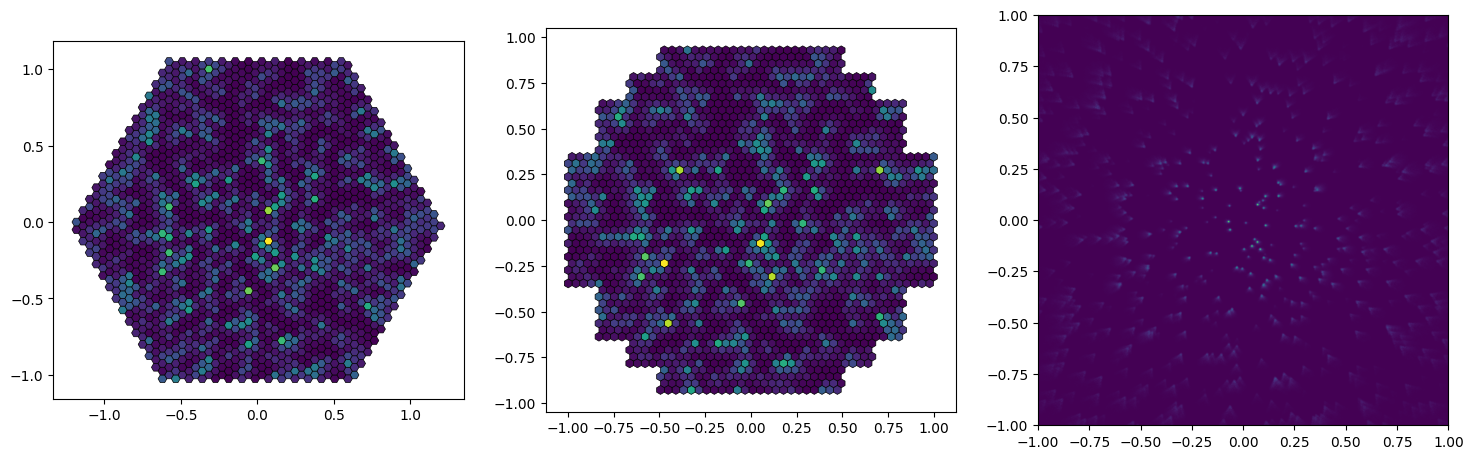

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax_flashcam = hexshow(image_flashcam, telescope.sensors[0], ax=ax[0])
ax_hess2 = hexshow(image_hess2, telescope.sensors[1], ax=ax[1])
ax_lid = squareshow(image_lid, telescope.sensors[2], ax=ax[2])

# Simulating Point Source:

In [10]:
N_points = 1

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-1, maxval=1)
y = jax.random.uniform(key2, N_points, minval=-1, maxval=1)
z = jnp.ones(N_points) * 1000

points = jnp.array([x,y,z]).T

f_points = np.ones(len(points))

In [11]:
%%time
image_flashcam = telescope(points, f_points, source_type='point', sensor_idx=0).block_until_ready()
image_hess2 = telescope(points, f_points, source_type='point', sensor_idx=1).block_until_ready()
image_lid = telescope(points, f_points, source_type='point', sensor_idx=2).block_until_ready()

CPU times: user 2.43 s, sys: 117 ms, total: 2.55 s
Wall time: 2.9 s


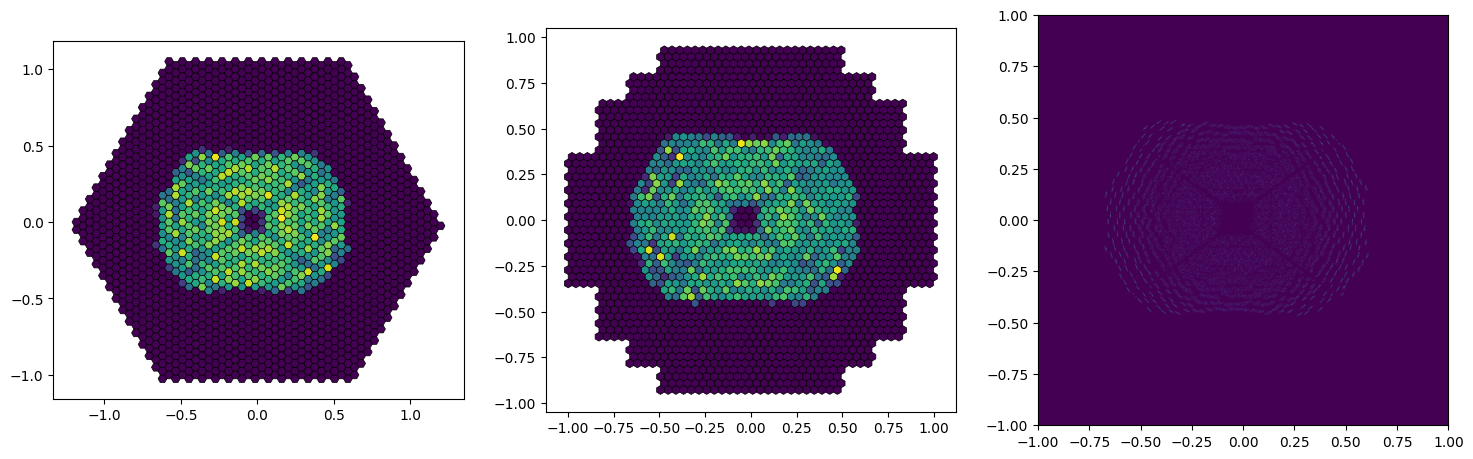

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax_flashcam = hexshow(image_flashcam, telescope.sensors[0], ax=ax[0])
ax_hess2 = hexshow(image_hess2, telescope.sensors[1], ax=ax[1])
ax_lid = squareshow(image_lid, telescope.sensors[2], ax=ax[2])